# Labo pratique : Réseaux neuronaux pour la reconnaissance de chiffres manuscrits, multi-classe 

Dans cet exercice, vous utiliserez un réseau neuronal pour reconnaître les chiffres manuscrits de 0 à 9.


# Outline
- [ 1 - Packages ](#1)
- [ 2 - ReLU Activation](#2)
- [ 3 - Softmax Function](#3)
  - [ Exercise 1](#ex01)
- [ 4 - Neural Networks](#4)
  - [ 4.1 Problem Statement](#4.1)
  - [ 4.2 Dataset](#4.2)
  - [ 4.3 Model representation](#4.3)
  - [ 4.4 Tensorflow Model Implementation](#4.4)
  - [ 4.5 Softmax placement](#4.5)
    - [ Exercise 2](#ex02)


<a name="1"></a>
## 1 - Packages 

Tout d'abord, exécutons la cellule ci-dessous pour importer tous les paquets dont vous aurez besoin au cours de ce travail.
- [numpy] (https://numpy.org/) est le paquetage fondamental pour le calcul scientifique avec Python.
- [matplotlib] (http://matplotlib.org) est une bibliothèque populaire pour tracer des graphiques en Python.
- [tensorflow] (https://www.tensorflow.org/) est une plateforme populaire pour l'apprentissage automatique.

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
%matplotlib widget
import matplotlib.pyplot as plt
plt.style.use('deeplearning.mplstyle')

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

from public_tests import * 

from autils import *
from lab_utils_softmax import plt_softmax
np.set_printoptions(precision=2)

<a name="2"></a>
## 2 - ReLU Activation
Cette semaine, une nouvelle activation a été introduite, l'unité linéaire rectifiée (ReLU). 
$$ a = max(0,z) \quad\quad\text {# ReLU function} $$

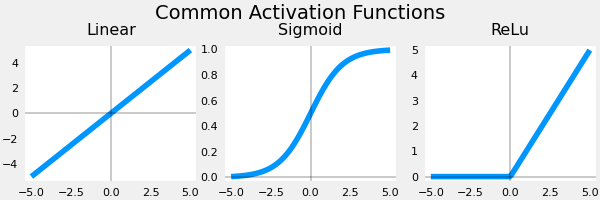

In [10]:
plt_act_trio()

<img align="right" src="./images/C2_W2_ReLu.png"     style=" width:380px; padding: 10px 20px; " >
L'exemple de la conférence de droite montre une application de la ReLU. Dans cet exemple, la caractéristique dérivée "conscience" n'est pas binaire, mais présente une plage de valeurs continue. La sigmoïde convient mieux aux situations binaires ou de type "on/off". La ReLU fournit une relation linéaire continue. En outre, elle dispose d'une plage "off" dans laquelle la sortie est égale à zéro.     
La caractéristique "off" fait de la ReLU une activation non linéaire. Pourquoi cette caractéristique est-elle nécessaire ? Cela permet à plusieurs unités de contribuer à la fonction résultante sans interférer. Ce point est examiné plus en détail dans le laboratoire optionnel de soutien. 

<a name="3"></a>
## 3 - Softmax Function
Un réseau neuronal multiclasse génère N sorties. Une sortie est sélectionnée comme réponse prédite. Dans la couche de sortie, un vecteur $\mathbf{z}$ est généré par une fonction linéaire qui est introduite dans une fonction softmax. La fonction softmax convertit $\mathbf{z}$ en une distribution de probabilité comme décrit ci-dessous. Après l'application de la fonction softmax, chaque sortie sera comprise entre 0 et 1 et la somme des sorties sera égale à 1. Elles peuvent être interprétées comme des probabilités. Plus les entrées du softmax sont importantes, plus les probabilités de sortie sont élevées.
<center>  <img  src="./images/C2_W2_NNSoftmax.PNG" width="600" />  

La fonction softmax peut être écrite :
$$a_j = \frac{e^{z_j}}{ \sum_{k=0}^{N-1}{e^{z_k} }} \tag{1}$$

Oû $z = \mathbf{w} \cdot \mathbf{x} + b$ et N est le nombre de caractéristiques/catégories dans la couche de sortie.  

<a name="ex01"></a>
### Exercise 1
Créons une implémentation NumPy :

In [11]:
# UNQ_C1
# GRADED CELL: my_softmax

def my_softmax(z):  
    """ Softmax converts a vector of values to a probability distribution.
    Args:
      z (ndarray (N,))  : input data, N features
    Returns:
      a (ndarray (N,))  : softmax of z
    """    
    ### START CODE HERE ### 
    ez = np.exp(z)
    a = ez/np.sum(ez)
    ### END CODE HERE ### 
    return a

In [12]:
z = np.array([1., 2., 3., 4.])
a = my_softmax(z)
atf = tf.nn.softmax(z)
print(f"my_softmax(z):         {a}")
print(f"tensorflow softmax(z): {atf}")

# BEGIN UNIT TEST  
test_my_softmax(my_softmax)
# END UNIT TEST  

my_softmax(z):         [0.03 0.09 0.24 0.64]
tensorflow softmax(z): [0.03 0.09 0.24 0.64]
 All tests passed.


Ci-dessous, faites varier les valeurs des entrées `z`. Notez en particulier comment l'exponentielle dans le numérateur amplifie les petites différences dans les valeurs. Notez également que la somme des valeurs de sortie est égale à un.

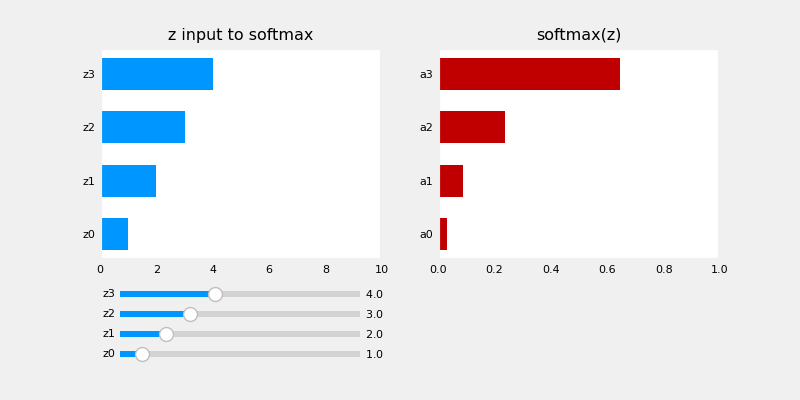

In [13]:
plt.close("all")
plt_softmax(my_softmax)

<a name="4"></a>
## 4 - Neural Networks

Dans le travail de la semaine dernière, vous avez mis en œuvre un réseau neuronal pour effectuer une classification binaire. Cette semaine, vous allez l'étendre à la classification multiclasse. Pour ce faire, vous utiliserez l'activation softmax.


<a name="4.1"></a>
### 4.1 Problem Statement

Dans cet exercice, vous utiliserez un réseau neuronal pour reconnaître dix chiffres manuscrits, de 0 à 9. Il s'agit d'une tâche de classification multiclasse où l'un des n choix est sélectionné. La reconnaissance automatisée de chiffres manuscrits est largement utilisée aujourd'hui, qu'il s'agisse de reconnaître des codes postaux sur des enveloppes de courrier ou des montants inscrits sur des chèques bancaires. 


<a name="4.2"></a>
### 4.2 Dataset

Vous commencerez par charger le jeu de données pour cette tâche. 
- La fonction `load_data()` montrée ci-dessous charge les données dans les variables `X` et `y`


- Le jeu de données contient 5000 exemples d'entraînement de chiffres manuscrits $^1$.  

    - Chaque exemple d'apprentissage est une image en niveaux de gris de 20 pixels x 20 pixels du chiffre. 
        - Chaque pixel est représenté par un nombre à virgule flottante indiquant l'intensité des niveaux de gris à cet endroit. 
        - La grille de pixels de 20 x 20 est "déroulée" en un vecteur à 400 dimensions. 
        - Chaque exemple d'apprentissage devient une seule ligne de notre matrice de données `X`. 
        - Nous obtenons ainsi une matrice `X` de 5000 x 400 où chaque ligne est un exemple d'apprentissage d'une image de chiffres manuscrits.

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- La deuxième partie de l'ensemble d'apprentissage est un vecteur dimensionnel 5000 x 1 `y` qui contient les étiquettes de l'ensemble d'apprentissage

    - `y = 0` si l'image est celle du chiffre `0`, `y = 4` si l'image est celle du chiffre `4` et ainsi de suite.

$^1$<sub> Il s'agit d'un sous-ensemble de l'ensemble de données de chiffres manuscrits MNIST.  (http://yann.lecun.com/exdb/mnist/)</sub>

In [14]:
# lecture des données
X, y = load_data()

#### 4.2.1 Afficher les variables
Familiarisez-vous avec votre ensemble de données.  
- Un bon point de départ est d'imprimer chaque variable et de voir ce qu'elle contient.

Le code ci-dessous affiche le premier élément des variables `X` et `y`.  

In [15]:
print ('The first element of X is: ', X[0])

The first element of X is:  [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02  8.04e-02
  2.67e-01  2.74e-01  2.79e-01  2.74e-01  2.25e-0

In [16]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  9


#### 4.2.2 Vérifier les dimensions de vos variables

Une autre façon de se familiariser avec vos données est de visualiser leurs dimensions. Veuillez imprimer la forme de `X` et `y` et voir combien d'exemples d'apprentissage vous avez dans votre jeu de données.

In [17]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)


#### 4.2.3 Visualisation des données

Vous commencerez par visualiser un sous-ensemble de l'ensemble d'apprentissage. 
- Dans la cellule ci-dessous, le code sélectionne aléatoirement 64 lignes de `X`, convertit chaque ligne en une image en niveaux de gris de 20 pixels par 20 pixels et affiche les images ensemble. 
- L'étiquette de chaque image est affichée au-dessus de l'image 

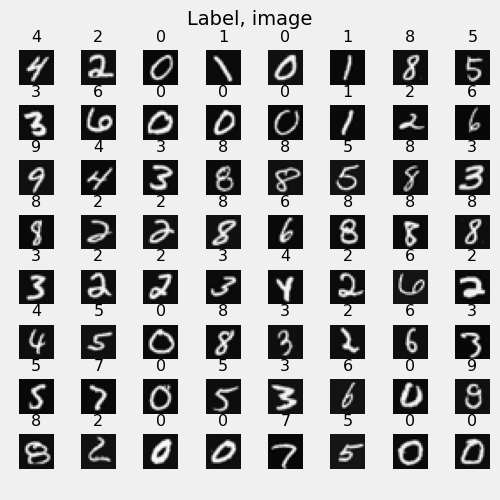

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)

<a name="4.3"></a>
### 4.3 Model representation

Le réseau neuronal que vous utiliserez dans le cadre de ce travail est illustré dans la figure ci-dessous. 
- Il comporte deux couches denses avec des activations ReLU, suivies d'une couche de sortie avec une activation linéaire. 
    - Rappelons que nos entrées sont des valeurs de pixels d'images numériques.
    - Comme les images sont de taille  $20\times20$, this gives us $400$ inputs  
    
<img src="images/C2_W2_Assigment_NN.png" width="600" height="450">

- Les paramètres ont des dimensions adaptées à un réseau neuronal comportant 25$ d'unités dans la couche 1, 15$ d'unités dans la couche 2 et 10$ d'unités de sortie dans la couche 3, une pour chaque chiffre.

    - Rappelons que les dimensions de ces paramètres sont déterminées comme suit :
        - Si le réseau compte $s_{in}$ unités dans une couche et $s_{out}$ unités dans la couche suivante, alors 
            - $W$ sera de dimension $s_{in} \times s_{out}$.
            - $b$ sera un vecteur avec $s_{out}$ éléments
  
    - Les formes de `W` et `b` sont donc les suivantes 
        - couche1 : La forme de `W1` est (400, 25) et la forme de `b1` est (25,)
        - couche2 : La forme de `W2` est (25, 15) et la forme de `b2` est : (15,)
        - couche3 : La forme de `W3` est (15, 10) et la forme de `b3` est : (10,)
>**Note:** Le vecteur de biais `b` peut être représenté comme un tableau 1-D (n,) ou 2-D (n,1). Tensorflow utilise une représentation 1-D et ce laboratoire va maintenir cette convention : 

<a name="4.4"></a>
### 4.4 Tensorflow Model Implementation


Les modèles Tensorflow sont construits couche par couche. Les dimensions d'entrée d'une couche ($s_{in}$ above) sont calculées pour vous. Vous spécifiez les *output dimensions* ce qui détermine la dimension d'entrée de la couche suivante. La dimension d'entrée de la première couche est dérivée de la taille des données d'entrée spécifiée dans le champ  `model.fit` ci-dessous. 
>**Note:** Il est également possible d'ajouter une couche d'entrée qui spécifie la dimension d'entrée de la première couche. Par exemple, il est possible d'ajouter une couche d'entrée qui précise la dimension d'entrée de la première couche :  
`tf.keras.Input(shape=(400,)),    #specify input shape`  
Nous l'inclurons ici pour éclairer le dimensionnement de certains modèles.

<a name="4.5"></a>
### 4.5 Softmax placement
Comme décrit dans le cours et dans le laboratoire optionnel sur les softmax, la stabilité numérique est améliorée si la softmax est groupée avec la fonction de perte plutôt qu'avec la couche de sortie pendant l'apprentissage. Ceci a des implications lors de la *construction* du modèle et de son *utilisation*.  
Construction :  
* La couche dense finale doit utiliser une activation "linéaire". Il s'agit en fait d'une absence d'activation. 
* Le `model.compile` l'indiquera en incluant `from_logits=True`.
`loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) `  
* Cela n'a pas d'incidence sur la forme de la cible. Dans le cas de SparseCategorialCrossentropy, la cible est le chiffre attendu, 0-9.
Utilisation du modèle :
* Les sorties ne sont pas des probabilités. Si des probabilités de sortie sont souhaitées, appliquer une fonction softmax.

### Exercise 2

Ci-dessous, en utilisant Keras [Sequential model](https://keras.io/guides/sequential_model/) et [Dense Layer](https://keras.io/api/layers/core_layers/dense/) avec une activation ReLU pour construire le réseau à trois couches décrit ci-dessus.

In [19]:
# UNQ_C2
# GRADED CELL: Sequential model
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        ### START CODE HERE ### 
        tf.keras.layers.InputLayer((400,)),
        tf.keras.layers.Dense(25, activation="relu", name="L1"),
        tf.keras.layers.Dense(15, activation="relu", name="L2"),
        tf.keras.layers.Dense(10, activation="linear", name="L3")
        ### END CODE HERE ### 
    ], name = "my_model" 
)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [20]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 25)                10025     
                                                                 
 L2 (Dense)                  (None, 15)                390       
                                                                 
 L3 (Dense)                  (None, 10)                160       
                                                                 
Total params: 10575 (41.31 KB)
Trainable params: 10575 (41.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# BEGIN UNIT TEST     
test_model(model, 10, 400)
# END UNIT TEST  

All tests passed!


Les nombres de paramètres indiqués dans le résumé correspondent au nombre d'éléments dans les tableaux de poids et de biais, comme indiqué ci-dessous.

Examinons encore les poids pour vérifier que tensorflow a produit les mêmes dimensions que celles que nous avons calculées ci-dessus.

In [22]:
[layer1, layer2, layer3] = model.layers

In [23]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


**Expected Output**
```
W1 shape = (400, 25), b1 shape = (25,)  
W2 shape = (25, 15), b2 shape = (15,)  
W3 shape = (15, 10), b3 shape = (10,)
```

Le code suivant :
* définit une fonction de perte, `SparseCategoricalCrossentropy` et indique que le softmax doit être inclus dans le calcul de la perte en ajoutant `from_logits=True`)
* définit un optimiseur. Un choix populaire est Adaptive Moment (Adam) qui a été décrit dans le cours.

In [24]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,y,
    epochs=40
)

Epoch 1/40
157/157 [==============================] - 2s 2ms/step - loss: 1.4968
Epoch 2/40
157/157 [==============================] - 0s 2ms/step - loss: 0.5761
Epoch 3/40
157/157 [==============================] - 0s 2ms/step - loss: 0.3871
Epoch 4/40
157/157 [==============================] - 0s 2ms/step - loss: 0.3185
Epoch 5/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2827
Epoch 6/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2558
Epoch 7/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2357
Epoch 8/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2165
Epoch 9/40
157/157 [==============================] - 0s 2ms/step - loss: 0.2025
Epoch 10/40
157/157 [==============================] - 0s 2ms/step - loss: 0.1840
Epoch 11/40
157/157 [==============================] - 0s 2ms/step - loss: 0.1753
Epoch 12/40
157/157 [==============================] - 0s 2ms/step - loss: 0.1643
Epoch 13/40
157/157 [====

#### Epochs and batches

Dans la déclaration `compile` ci-dessus, le nombre de `epochs` a été fixé à 100. Ceci spécifie que l'ensemble des données doit être appliqué 100 fois pendant l'apprentissage.  Pendant l'apprentissage, vous verrez une sortie décrivant la progression de l'apprentissage qui ressemble à ceci :
```
Epoch 1/100
157/157 [==============================] - 0s 1ms/step - loss: 2.2770
```
La première ligne, `Epoch 1/100`, décrit l'époque à laquelle le modèle fonctionne actuellement. Pour des raisons d'efficacité, le jeu de données d'entraînement est divisé en "lots". La taille par défaut d'un lot dans Tensorflow est de 32. Il y a 5000 exemples dans notre jeu de données, soit environ 157 lots. La notation sur la 2ème ligne `157/157 [====` décrit quel lot a été exécuté.

#### Perte (coût)
Dans le cours 1, nous avons appris à suivre la progression de la descente de gradient en surveillant le coût. Idéalement, le coût diminue au fur et à mesure que le nombre d'itérations de l'algorithme augmente. Tensorflow se réfère au coût comme `loss`. Ci-dessus, vous avez vu la perte affichée à chaque époque pendant que `model.fit` s'exécutait. La méthode [model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model) retourne une variété de métriques incluant la perte. Celle-ci est capturée dans la variable `history` ci-dessus. Elle peut être utilisée pour examiner la perte dans un graphique, comme indiqué ci-dessous.

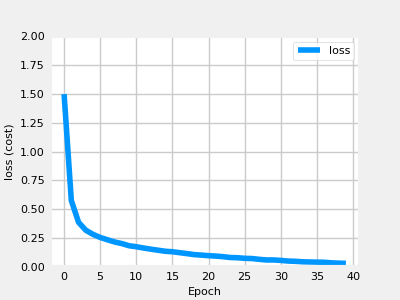

In [25]:
plot_loss_tf(history)

#### Prédiction 
Pour faire une prédiction, utilisez Keras `predict`. Ci-dessous, X[1015] contient l'image d'un deux.

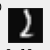

1/1 [==============================] - 0s 103ms/step
 predicting a Two: 
[[-10.12   5.63   7.16   3.61 -11.85  -8.84  -5.29   4.37  -4.62  -8.97]]
 Largest Prediction index: 2


In [26]:
image_of_two = X[1015]
display_digit(image_of_two)

prediction = model.predict(image_of_two.reshape(1,400))  # prediction

print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

La sortie la plus importante est prediction[2], qui indique que le chiffre prédit est un "2". Si le problème ne nécessite qu'une sélection, celle-ci est suffisante. Utilisez NumPy [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) pour la sélectionner. Si le problème requiert une probabilité, un softmax est nécessaire :

In [30]:
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")

 predicting a Two. Probability vector: 
[[2.40e-08 1.67e-01 7.64e-01 2.20e-02 4.24e-09 8.65e-08 3.00e-06 4.73e-02
  5.87e-06 7.55e-08]]
Total of predictions: 1.000


Pour renvoyer un entier représentant la cible prédite, vous voulez l'indice de la plus grande probabilité. Pour ce faire, on utilise la fonction Numpy [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

In [31]:
yhat = np.argmax(prediction_p)

print(f"np.argmax(prediction_p): {yhat}")

np.argmax(prediction_p): 2


Comparons les prédictions aux étiquettes pour un échantillon aléatoire de 64 chiffres. Cette opération prend un peu de temps.

1/1 [==============================] - 0s 21ms/step


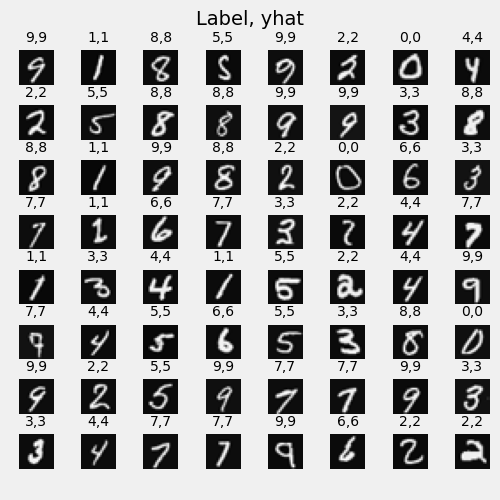

In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}",fontsize=10)
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=14)
plt.show()

Examinons quelques-unes des erreurs. 
>Remarque : l'augmentation du nombre d'époques d'apprentissage peut éliminer les erreurs sur cet ensemble de données.

1/1 [==============================] - 0s 21ms/step
20 errors out of 5000 images


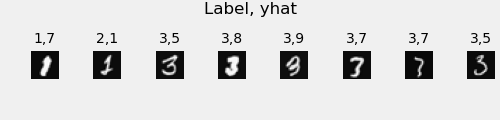

In [33]:
print( f"{display_errors(model,X,y)} errors out of {len(X)} images")

### Félicitations !
Vous avez réussi à construire et à utiliser un réseau neuronal pour effectuer une classification multiclasse.